# CNN Notebook

In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from urllib.request import urlopen
import cv2

from tensorflow.keras import datasets, layers, models
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

# Data for Convolutional Neural Network

Sources for reference:

- [A Comprehensive Guide to Convolutional Neural Network](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)
- [Tensorflow Convolutional Netural Network ](https://www.tensorflow.org/tutorials/images/cnn)
- [Pooling for CNN](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)

- [Keras Conv2d and Convolutional Layers](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)

In [2]:
df = pd.read_csv('raw_data.csv', index_col=0).reset_index().drop(columns='index')

def url2data(url): 
  req = urlopen(url)
  image = np.asarray(bytearray(req.read()), dtype=np.uint8)
  image_vec = cv2.imdecode(image, cv2.IMREAD_COLOR) 
  image_vec = cv2.cvtColor(image_vec , cv2.COLOR_BGR2RGB)
  return image_vec

df['img_data'] = df['album_images'].apply(url2data)
df['genre'] = df['genre'].astype('category')
df['genre_cat'] = df['genre'].cat.codes

df

,artists,song,album_images,playlist_name,genre,img_data,genre_cat
0,"['DDG', 'Blueface']",Moonwalking in Calabasas (feat. Blueface) [Remix],https://i.scdn.co/image/ab67616d00001e02620247...,RapCaviar,Rap,"[[[6, 0, 6], [89, 79, 87], [219, 206, 215], [2...",5
1,['CJ'],Whoopty,https://i.scdn.co/image/ab67616d00001e027af305...,RapCaviar,Rap,"[[[0, 1, 0], [0, 2, 1], [0, 2, 1], [0, 2, 1], ...",5
2,['Jack Harlow'],Tyler Herro,https://i.scdn.co/image/ab67616d00001e02b4e9cc...,RapCaviar,Rap,"[[[246, 245, 243], [246, 245, 243], [246, 245,...",5
3,['Pop Smoke'],Shoot For The Stars Aim For The Moon,https://i.scdn.co/image/ab67616d00001e0277ada0...,RapCaviar,Rap,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5
4,"['21 Savage', 'Metro Boomin']",SAVAGE MODE II,https://i.scdn.co/image/ab67616d00001e02aa5790...,RapCaviar,Rap,"[[[40, 24, 11], [51, 22, 16], [32, 24, 3], [91...",5
...,...,...,...,...,...,...,...
588,['DREAMCATCHER'],[Dystopia : Lose Myself],https://i.scdn.co/image/ab67616d00001e02f425b2...,K-Pop Daebak,K-Pop,"[[[1, 0, 6], [1, 0, 5], [0, 0, 4], [0, 1, 5], ...",3
589,['Hyolyn'],SAY MY NAME,https://i.scdn.co/image/ab67616d00001e025ed4f8...,K-Pop Daebak,K-Pop,"[[[28, 15, 22], [28, 15, 22], [29, 16, 23], [3...",3
590,['TAEMIN'],Never Gonna Dance Again : Act 1 - The 3rd Album,https://i.scdn.co/image/ab67616d00001e029756c6...,K-Pop Daebak,K-Pop,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
591,['ITZY'],It'z Me,https://i.scdn.co/image/ab67616d00001e0286e407...,K-Pop Daebak,K-Pop,"[[[11, 41, 95], [11, 41, 95], [12, 42, 96], [1...",3


In [3]:
not_grayscale = df['img_data'].apply(lambda arr: len(arr.shape)==3)

# There appear to be 5 grayscale images, as indicated by the lack of rbg dimensionality. 
# For the sake of simplicity in our model, let's filter those out.

df = df[not_grayscale].reset_index().drop(columns='index')

In [5]:
not_300x300 = df['img_data'].apply(lambda arr: arr.shape != (300,300,3))
to_fix = df[not_300x300]

In [6]:
def img_padder(arr):
  shp = np.shape(arr)
  img = arr.transpose(2,0,1)

  leftPad = round(float((300 - shp[0])) / 2)
  rightPad = round(float(300 - shp[0]) - leftPad)
  topPad = round(float((300 - shp[1])) / 2)
  bottomPad = round(float(300 - shp[1]) - topPad)
  pads = ((leftPad,rightPad),(topPad,bottomPad))

  img_arr = np.ndarray((3,300,300),np.int)
  for i,x in enumerate(img):
      cons = np.int(np.median(x))
      x_p = np.pad(x,pads,
                  'constant', 
                  constant_values=cons)
      img_arr[i,:,:] = x_p

  ii = np.uint8(img_arr).transpose(1,2,0)
  return ii

In [ ]:
to_fix['img_data'] = to_fix['img_data'].apply(img_padder)

In [8]:
df.at[to_fix.index, 'img_data'] = to_fix['img_data']

In [9]:
X = df[['img_data']]
y = df[['genre_cat']]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
X_train = np.asarray(X_train['img_data']) / 255.0
X_test = np.asarray(X_test['img_data']) / 255.0
y_train = np.asarray(y_train['genre_cat'])
y_test = np.asarray(y_test['genre_cat'])

In [12]:
for i in np.arange(len(X_train)):
    if X_train[i].shape != (300, 300, 3):
        print(i)

In [13]:
X_train = np.array([X_train[i] for i in range(len(X_train))])
X_test = np.array([X_test[i] for i in range(len(X_test))])
y_train = np.array([y_train[i] for i in range(len(y_train))])
y_test = np.array([y_test[i] for i in range(len(y_test))])

# Model for Convolutional Neural Network

## Phase 1

In [39]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(8))

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(X_train, y_train, batch_size = 60 ,epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
8/8 [==============================] - 2s 216ms/step - loss: 3.0019 - accuracy: 0.1081 - val_loss: 2.0669 - val_accuracy: 0.1678
Epoch 2/25
8/8 [==============================] - 1s 157ms/step - loss: 2.0363 - accuracy: 0.2230 - val_loss: 2.0979 - val_accuracy: 0.1477
Epoch 3/25
8/8 [==============================] - 1s 160ms/step - loss: 2.0004 - accuracy: 0.2432 - val_loss: 2.0285 - val_accuracy: 0.1745
Epoch 4/25
8/8 [==============================] - 1s 157ms/step - loss: 1.9309 - accuracy: 0.2410 - val_loss: 2.0144 - val_accuracy: 0.2819
Epoch 5/25
8/8 [==============================] - 1s 160ms/step - loss: 1.8403 - accuracy: 0.3153 - val_loss: 1.9639 - val_accuracy: 0.2752
Epoch 6/25
8/8 [==============================] - 1s 161ms/step - loss: 1.6537 - accuracy: 0.3964 - val_loss: 2.0467 - val_accuracy: 0.2416
Epoch 7/25
8/8 [==============================] - 1s 161ms/step - loss: 1.4273 - accuracy: 0.5180 - val_loss: 2.0839 - val_accuracy: 0.2483
Epoch 8/25
8/8 [====

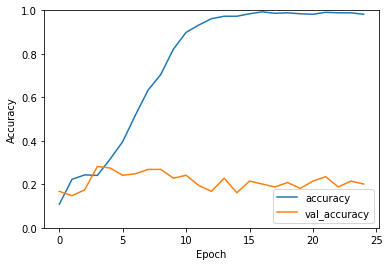

In [41]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

## Phase 2

In [28]:
model = models.Sequential()

model.add(layers.Conv2D(16, (7,7), activation='relu', input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(8, activation='softmax'))

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(X_train, y_train, batch_size = 60 ,epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
8/8 [==============================] - 1s 146ms/step - loss: 1.9457 - accuracy: 0.3423 - val_loss: 2.0781 - val_accuracy: 0.1879
Epoch 2/25
8/8 [==============================] - 1s 121ms/step - loss: 2.0393 - accuracy: 0.2275 - val_loss: 2.0642 - val_accuracy: 0.2013
Epoch 3/25
8/8 [==============================] - 1s 119ms/step - loss: 1.9664 - accuracy: 0.3086 - val_loss: 2.0751 - val_accuracy: 0.1611
Epoch 4/25
8/8 [==============================] - 1s 120ms/step - loss: 1.9295 - accuracy: 0.3559 - val_loss: 2.0536 - val_accuracy: 0.1812
Epoch 5/25
8/8 [==============================] - 1s 116ms/step - loss: 1.8698 - accuracy: 0.4257 - val_loss: 2.0438 - val_accuracy: 0.1946
Epoch 6/25
8/8 [==============================] - 1s 120ms/step - loss: 1.8257 - accuracy: 0.4527 - val_loss: 2.0441 - val_accuracy: 0.2081
Epoch 7/25
8/8 [==============================] - 1s 121ms/step - loss: 1.7948 - accuracy: 0.4752 - val_loss: 2.0514 - val_accuracy: 0.1745
Epoch 8/25
8/8 [====

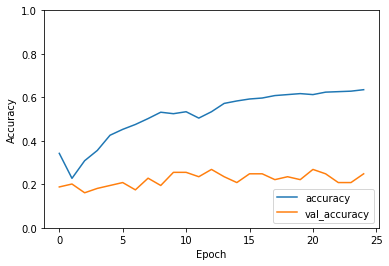

In [31]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

## Phase 3

In [55]:
model = models.Sequential()

model.add(layers.Conv2D(16, (7,7), activation='relu', input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(8, activation='softmax'))

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(X_train, y_train, batch_size = 222, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
2/2 [==============================] - 1s 728ms/step - loss: 2.0734 - accuracy: 0.1351 - val_loss: 2.0630 - val_accuracy: 0.1477
Epoch 2/25
2/2 [==============================] - 1s 472ms/step - loss: 2.0531 - accuracy: 0.1554 - val_loss: 2.0610 - val_accuracy: 0.1678
Epoch 3/25
2/2 [==============================] - 1s 486ms/step - loss: 2.0521 - accuracy: 0.1712 - val_loss: 2.0636 - val_accuracy: 0.1678
Epoch 4/25
2/2 [==============================] - 1s 471ms/step - loss: 2.0424 - accuracy: 0.1892 - val_loss: 2.0648 - val_accuracy: 0.1611
Epoch 5/25
2/2 [==============================] - 1s 482ms/step - loss: 2.0410 - accuracy: 0.1757 - val_loss: 2.0630 - val_accuracy: 0.1477
Epoch 6/25
2/2 [==============================] - 1s 454ms/step - loss: 2.0420 - accuracy: 0.1779 - val_loss: 2.0598 - val_accuracy: 0.1544
Epoch 7/25
2/2 [==============================] - 1s 462ms/step - loss: 2.0391 - accuracy: 0.1757 - val_loss: 2.0573 - val_accuracy: 0.1879
Epoch 8/25
2/2 [====

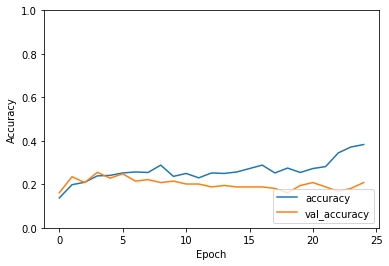

In [52]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

## Phase 4

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(16, (7,7), activation='relu', input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.Dropout(0.10))
model.add(layers.MaxPooling2D(2,2))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.10))

model.add(layers.Dense(8, activation='softmax'))



In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(X_train, y_train, batch_size = 160 ,epochs=35, validation_data=(X_test, y_test))

Epoch 1/35
3/3 [==============================] - 1s 297ms/step - loss: 2.0796 - accuracy: 0.1532 - val_loss: 2.1259 - val_accuracy: 0.1477
Epoch 2/35
3/3 [==============================] - 1s 212ms/step - loss: 2.0966 - accuracy: 0.1779 - val_loss: 2.1260 - val_accuracy: 0.1477
Epoch 3/35
3/3 [==============================] - 1s 207ms/step - loss: 2.0949 - accuracy: 0.1779 - val_loss: 2.1258 - val_accuracy: 0.1477
Epoch 4/35
3/3 [==============================] - 1s 201ms/step - loss: 2.0830 - accuracy: 0.1869 - val_loss: 2.1262 - val_accuracy: 0.1342
Epoch 5/35
3/3 [==============================] - 1s 213ms/step - loss: 2.0578 - accuracy: 0.2072 - val_loss: 2.1210 - val_accuracy: 0.1477
Epoch 6/35
3/3 [==============================] - 1s 205ms/step - loss: 2.0551 - accuracy: 0.2117 - val_loss: 2.0917 - val_accuracy: 0.1611
Epoch 7/35
3/3 [==============================] - 1s 218ms/step - loss: 2.0003 - accuracy: 0.2590 - val_loss: 2.0396 - val_accuracy: 0.2215
Epoch 8/35
3/3 [====

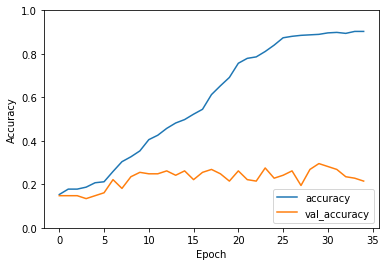

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(16, (7,7), activation='relu', input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.10))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.10))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.10))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.10))
model.add(layers.Flatten())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(X_train, y_train, batch_size = 444 ,epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
1/1 [==============================] - 0s 298ms/step - loss: 2.0771 - accuracy: 0.1779 - val_loss: 2.0800 - val_accuracy: 0.1477
Epoch 2/25
1/1 [==============================] - 1s 737ms/step - loss: 2.0726 - accuracy: 0.1734 - val_loss: 2.0790 - val_accuracy: 0.1477
Epoch 3/25
1/1 [==============================] - 1s 683ms/step - loss: 2.0770 - accuracy: 0.1712 - val_loss: 2.0734 - val_accuracy: 0.1477
Epoch 4/25
1/1 [==============================] - 1s 681ms/step - loss: 2.0640 - accuracy: 0.1712 - val_loss: 2.0723 - val_accuracy: 0.1678
Epoch 5/25
1/1 [==============================] - 1s 737ms/step - loss: 2.0536 - accuracy: 0.2027 - val_loss: 2.0717 - val_accuracy: 0.1477
Epoch 6/25
1/1 [==============================] - 1s 732ms/step - loss: 2.0537 - accuracy: 0.1712 - val_loss: 2.0692 - val_accuracy: 0.1477
Epoch 7/25
1/1 [==============================] - 1s 558ms/step - loss: 2.0556 - accuracy: 0.1757 - val_loss: 2.0674 - val_accuracy: 0.1477
Epoch 8/25
1/1 [====

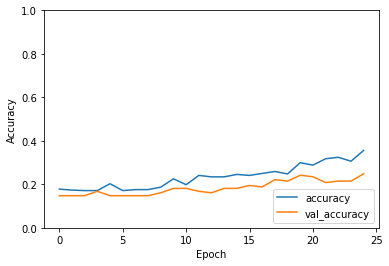

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(300, 300, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))

# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size = 100 ,epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
5/5 [==============================] - 7s 1s/step - loss: 2.0899 - accuracy: 0.1464 - val_loss: 2.0818 - val_accuracy: 0.1544
Epoch 2/25
5/5 [==============================] - 4s 804ms/step - loss: 1.9956 - accuracy: 0.2770 - val_loss: 2.0772 - val_accuracy: 0.1477
Epoch 3/25
5/5 [==============================] - 4s 813ms/step - loss: 1.9480 - accuracy: 0.3536 - val_loss: 2.0686 - val_accuracy: 0.1812
Epoch 4/25
5/5 [==============================] - 4s 818ms/step - loss: 1.9281 - accuracy: 0.3761 - val_loss: 2.0754 - val_accuracy: 0.1544
Epoch 5/25
5/5 [==============================] - 4s 821ms/step - loss: 1.8519 - accuracy: 0.4730 - val_loss: 2.0888 - val_accuracy: 0.1007
Epoch 6/25
5/5 [==============================] - 4s 822ms/step - loss: 1.7915 - accuracy: 0.5180 - val_loss: 2.0802 - val_accuracy: 0.1544
Epoch 7/25
5/5 [==============================] - 4s 831ms/step - loss: 1.7067 - accuracy: 0.6284 - val_loss: 2.0653 - val_accuracy: 0.1812
Epoch 8/25
5/5 [=======

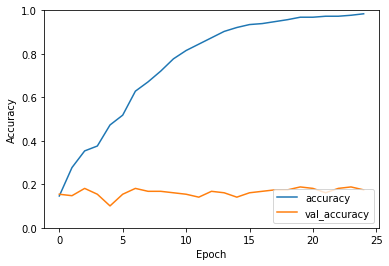

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

- MaxPooling (2,4) allows for consistent growth of val accuracy and accuracy.


- Removing one dense layer, keeping 8, results in more overfitting but increased validation.

- Batch size original is 60, increasing it results in ??? 111 is favorable, 222 is meh?

- Including dropout to further generalize results in better validation comparable to accuracy! Did dropout (0.2, 0.2), and (0.2, 0.4, 0.2) performed

In [ ]:

unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 13, 1: 22, 2: 25, 3: 19, 4: 28, 5: 11, 6: 22, 7: 9}

In [ ]:
pred = model.predict_classes(X_test)
unique, counts = np.unique(pred, return_counts=True)
dict(zip(unique, counts))